In [16]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

In [2]:
#First reload the data we generated in 1_notmnist.ipynb
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
#Reformat into a shape that's more adapted to the models we're going to train:
#  -data as a flat matrix,
#  -labels as float 1-hot encodings.

image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


Initialized with beta 0.000100
Minibatch loss at step 0: 21.909044
Minibatch accuracy: 10.2%
Validation accuracy: 12.0%
Minibatch loss at step 500: 1.545076
Minibatch accuracy: 75.0%
Validation accuracy: 75.6%
Minibatch loss at step 1000: 1.440026
Minibatch accuracy: 80.5%
Validation accuracy: 76.4%
Minibatch loss at step 1500: 0.949756
Minibatch accuracy: 80.5%
Validation accuracy: 77.6%
Minibatch loss at step 2000: 1.063383
Minibatch accuracy: 84.4%
Validation accuracy: 77.6%
Minibatch loss at step 2500: 1.028002
Minibatch accuracy: 78.9%
Validation accuracy: 78.4%
Minibatch loss at step 3000: 1.027636
Minibatch accuracy: 76.6%
Validation accuracy: 79.2%
Test accuracy: 86.8%
################################################
Initialized with beta 0.000127
Minibatch loss at step 0: 19.682852
Minibatch accuracy: 7.0%
Validation accuracy: 11.3%
Minibatch loss at step 500: 1.495443
Minibatch accuracy: 77.3%
Validation accuracy: 75.3%
Minibatch loss at step 1000: 1.327077
Minibatch accuracy

Minibatch loss at step 500: 2.577095
Minibatch accuracy: 82.0%
Validation accuracy: 76.5%
Minibatch loss at step 1000: 1.532017
Minibatch accuracy: 78.9%
Validation accuracy: 79.0%
Minibatch loss at step 1500: 0.776887
Minibatch accuracy: 85.9%
Validation accuracy: 80.9%
Minibatch loss at step 2000: 0.713898
Minibatch accuracy: 90.6%
Validation accuracy: 81.2%
Minibatch loss at step 2500: 0.765069
Minibatch accuracy: 80.5%
Validation accuracy: 81.8%
Minibatch loss at step 3000: 0.731255
Minibatch accuracy: 82.0%
Validation accuracy: 82.0%
Test accuracy: 89.1%
################################################
Initialized with beta 0.001833
Minibatch loss at step 0: 23.264885
Minibatch accuracy: 9.4%
Validation accuracy: 10.3%
Minibatch loss at step 500: 2.497534
Minibatch accuracy: 81.2%
Validation accuracy: 76.3%
Minibatch loss at step 1000: 1.441028
Minibatch accuracy: 78.9%
Validation accuracy: 80.2%
Minibatch loss at step 1500: 0.688013
Minibatch accuracy: 84.4%
Validation accuracy: 

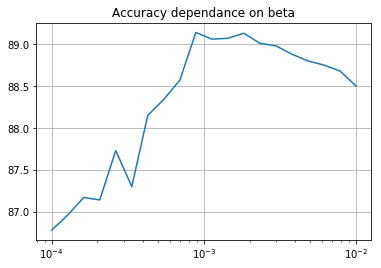

In [17]:
#Problem 1-a
#Introduce and tune L2 regularization for both logistic and neural network models.
#Let's now switch to stochastic gradient descent training instead, which is much faster.

batch_size = 128
beta_range=np.logspace(-4, -2, 20)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_l2=tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  vars   = tf.trainable_variables() 
  lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in vars if 'biases' not in v.name ]) * beta_l2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))+lossL2
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
    
    
num_steps = 3001
accuracy_test=[]
for beta in beta_range:
    
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("Initialized with beta %f" %beta)
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_l2 : beta}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
      test_validation_score=accuracy(test_prediction.eval(), test_labels)
      print("Test accuracy: %.1f%%" % test_validation_score)
      print("################################################")
      accuracy_test.append(test_validation_score)
best_beta=beta_range[np.argmax(accuracy_test)]
accuracy_max=max(accuracy_test)

plt.semilogx(beta_range, accuracy_test)
plt.grid(True)
plt.title('Accuracy dependance on beta')
plt.show()

In [28]:
#Problem 1-b
#Introduce and tune L2 regularization for both logistic and neural network models.
batch_size = 128
hidden_layer=1024
beta_range=np.logspace(-4,-2,20)


graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_l2=tf.placeholder(tf.float32)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_layer]))
  biases1 = tf.Variable(tf.zeros([hidden_layer]))
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_layer, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  y=tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(y, weights2) + biases2
  vars   = tf.trainable_variables() 
  lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in vars if 'biases' not in v.name ])
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))+lossL2
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  y_val=tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(y_val, weights2) + biases2)

  y_test=tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(y_test, weights2) + biases2)
    
    
num_steps = 3001
for beta in beta_range:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized with beta %f" %beta)
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_l2:beta}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
              print("Minibatch loss at step %d: %f" % (step, l))
              print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
              print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        test_accuracy=accuracy(test_prediction.eval(), test_labels)
        print("Test accuracy: %.1f%%" % test_accuracy)
        print("###################################")


Initialized with beta 0.000100
Minibatch loss at step 0: 704.940674
Minibatch accuracy: 8.6%
Validation accuracy: 34.1%
Minibatch loss at step 500: 197.624557
Minibatch accuracy: 83.6%
Validation accuracy: 80.6%
Minibatch loss at step 1000: 116.306084
Minibatch accuracy: 79.7%
Validation accuracy: 80.7%
Minibatch loss at step 1500: 69.253609
Minibatch accuracy: 91.4%
Validation accuracy: 81.6%
Minibatch loss at step 2000: 41.397430
Minibatch accuracy: 88.3%
Validation accuracy: 84.4%
Minibatch loss at step 2500: 25.382423
Minibatch accuracy: 85.2%
Validation accuracy: 85.2%
Minibatch loss at step 3000: 15.543882
Minibatch accuracy: 85.9%
Validation accuracy: 86.5%
Test accuracy: 92.9%
###################################
Initialized with beta 0.000127
Minibatch loss at step 0: 641.424805
Minibatch accuracy: 12.5%
Validation accuracy: 35.3%
Minibatch loss at step 500: 204.560699
Minibatch accuracy: 79.7%
Validation accuracy: 80.2%
Minibatch loss at step 1000: 118.050323
Minibatch accurac

Validation accuracy: 80.6%
Minibatch loss at step 1000: 115.546242
Minibatch accuracy: 81.2%
Validation accuracy: 81.4%
Minibatch loss at step 1500: 69.596581
Minibatch accuracy: 87.5%
Validation accuracy: 83.0%
Minibatch loss at step 2000: 41.569412
Minibatch accuracy: 89.1%
Validation accuracy: 84.8%
Minibatch loss at step 2500: 25.430202
Minibatch accuracy: 89.1%
Validation accuracy: 85.3%
Minibatch loss at step 3000: 15.584491
Minibatch accuracy: 87.5%
Validation accuracy: 86.3%
Test accuracy: 93.0%
###################################
Initialized with beta 0.001833
Minibatch loss at step 0: 647.863159
Minibatch accuracy: 11.7%
Validation accuracy: 32.7%
Minibatch loss at step 500: 197.737137
Minibatch accuracy: 82.8%
Validation accuracy: 77.3%
Minibatch loss at step 1000: 116.238586
Minibatch accuracy: 75.8%
Validation accuracy: 82.1%
Minibatch loss at step 1500: 69.158440
Minibatch accuracy: 88.3%
Validation accuracy: 83.6%
Minibatch loss at step 2000: 41.520481
Minibatch accuracy

IndexError: index 119 is out of bounds for axis 0 with size 20

In [40]:
#Problem 2
#Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

batch_size = 128
hidden_layer=1024
few_batch_size=batch_size*5




graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_layer]))
  biases1 = tf.Variable(tf.zeros([hidden_layer]))
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_layer, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  y=tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  logits = tf.matmul(y, weights2) + biases2
  vars   = tf.trainable_variables() 
  lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in vars if 'biases' not in v.name ]) * 0.001
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))+lossL2
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  y_val=tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(y_val, weights2) + biases2)

  y_test=tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(y_test, weights2) + biases2)
    



small_train_dataset=train_dataset[:few_batch_size,:]
small_train_labels=train_labels[:few_batch_size, :]

    
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (small_train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = small_train_dataset[offset:(offset + batch_size), :]
    batch_labels = small_train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 631.048584
Minibatch accuracy: 8.6%
Validation accuracy: 22.8%
Minibatch loss at step 500: 190.273987
Minibatch accuracy: 100.0%
Validation accuracy: 74.5%
Minibatch loss at step 1000: 115.392540
Minibatch accuracy: 100.0%
Validation accuracy: 74.5%
Minibatch loss at step 1500: 69.980354
Minibatch accuracy: 100.0%
Validation accuracy: 74.5%
Minibatch loss at step 2000: 42.440010
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 2500: 25.738218
Minibatch accuracy: 100.0%
Validation accuracy: 74.8%
Minibatch loss at step 3000: 15.609816
Minibatch accuracy: 100.0%
Validation accuracy: 75.2%
Test accuracy: 82.8%


In [48]:
#Problem 3-a
#Introduce Dropout on the hidden layer of the neural network

#Problem 2
#Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

batch_size = 128
hidden_layer=1024
few_batch_size=batch_size*5




graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_layer]))
  biases1 = tf.Variable(tf.zeros([hidden_layer]))
  weights2 = tf.Variable(
    tf.truncated_normal([hidden_layer, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  y=tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  y=tf.nn.dropout(y,0.5)
  logits = tf.matmul(y, weights2) + biases2
  vars   = tf.trainable_variables() 
  lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in vars if 'biases' not in v.name ]) * 0.001
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))+lossL2
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  y_val=tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(y_val, weights2) + biases2)

  y_test=tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(y_test, weights2) + biases2)
    




    
num_steps = 7001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
    valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 764.435303
Minibatch accuracy: 13.3%
Validation accuracy: 34.8%
Minibatch loss at step 500: 214.757812
Minibatch accuracy: 78.1%
Validation accuracy: 80.2%
Minibatch loss at step 1000: 122.681618
Minibatch accuracy: 73.4%
Validation accuracy: 79.8%
Minibatch loss at step 1500: 72.521393
Minibatch accuracy: 81.2%
Validation accuracy: 81.6%
Minibatch loss at step 2000: 43.089493
Minibatch accuracy: 85.9%
Validation accuracy: 82.9%
Minibatch loss at step 2500: 25.805376
Minibatch accuracy: 82.0%
Validation accuracy: 84.2%
Minibatch loss at step 3000: 15.811578
Minibatch accuracy: 84.4%
Validation accuracy: 84.9%
Minibatch loss at step 3500: 9.893163
Minibatch accuracy: 84.4%
Validation accuracy: 85.3%
Minibatch loss at step 4000: 6.166235
Minibatch accuracy: 89.1%
Validation accuracy: 86.3%
Minibatch loss at step 4500: 3.946677
Minibatch accuracy: 87.5%
Validation accuracy: 86.3%
Minibatch loss at step 5000: 2.607092
Minibatch accuracy: 89.1%
Validati

In [49]:
#Problem 3-b

small_train_dataset=train_dataset[:few_batch_size,:]
small_train_labels=train_labels[:few_batch_size, :]

    
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (small_train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = small_train_dataset[offset:(offset + batch_size), :]
    batch_labels = small_train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 833.454895
Minibatch accuracy: 8.6%
Validation accuracy: 32.7%
Minibatch loss at step 500: 192.773895
Minibatch accuracy: 99.2%
Validation accuracy: 78.1%
Minibatch loss at step 1000: 116.401932
Minibatch accuracy: 100.0%
Validation accuracy: 79.0%
Minibatch loss at step 1500: 70.758438
Minibatch accuracy: 99.2%
Validation accuracy: 79.0%
Minibatch loss at step 2000: 42.842384
Minibatch accuracy: 100.0%
Validation accuracy: 79.2%
Minibatch loss at step 2500: 25.985039
Minibatch accuracy: 100.0%
Validation accuracy: 79.5%
Minibatch loss at step 3000: 15.759997
Minibatch accuracy: 100.0%
Validation accuracy: 79.1%
Test accuracy: 86.2%


In [82]:
#Problem 4
#Try to get the best performance you can using a multi-layer model! The best is 97.1%.


batch_size = 128
hidden_layer_1=1024
hidden_layer_2= 500
hidden_layer_3=100

keep_prob_1=0.8
keep_prob_2=0.8
keep_prob_3=0.5


graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # Variables.
    W_in = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_1],stddev=np.sqrt(2.0 / (image_size*image_size))))
    B_in = tf.Variable(tf.zeros([hidden_layer_1]))
    
    W_h1 = tf.Variable(tf.truncated_normal([hidden_layer_1, hidden_layer_2],stddev=np.sqrt(2.0 / hidden_layer_1)))
    B_h1 = tf.Variable(tf.zeros([hidden_layer_2]))
    
    W_h2 = tf.Variable(tf.truncated_normal([hidden_layer_2, hidden_layer_3],stddev=np.sqrt(2.0 / hidden_layer_2)))
    B_h2 = tf.Variable(tf.zeros([hidden_layer_3]))
    
    W_out = tf.Variable(tf.truncated_normal([hidden_layer_3, num_labels],stddev=np.sqrt(2.0 / hidden_layer_3)))
    B_out = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    y=tf.nn.relu(tf.matmul(tf_train_dataset, W_in) + B_in)
    #y=tf.nn.dropout(y,keep_prob_1)
    y1=tf.nn.relu(tf.matmul(y, W_h1) + B_h1)
    #y1=tf.nn.dropout(y1,keep_prob_2)
    y2=tf.nn.relu(tf.matmul(y1, W_h2) + B_h2)
    #y2=tf.nn.dropout(y2,keep_prob_3)    
    logits = tf.matmul(y2, W_out) + B_out
    #vars   = tf.trainable_variables() 
    #lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in vars if 'B' not in v.name ]) * 0.001
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))+0.001*(
            tf.nn.l2_loss(W_in)+tf.nn.l2_loss(W_h1)+tf.nn.l2_loss(W_h2)+tf.nn.l2_loss(W_out))
  
    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)

    y_val1 = tf.nn.relu(tf.matmul(tf_valid_dataset, W_in) + B_in)
    y_val2 = tf.nn.relu(tf.matmul(y_val1, W_h1) + B_h1)
    y_val3 = tf.nn.relu(tf.matmul(y_val2, W_h2) + B_h2)
    valid_prediction = tf.nn.softmax(tf.matmul(y_val3, W_out) + B_out)

    y_test1 = tf.nn.relu(tf.matmul(tf_test_dataset, W_in) + B_in)
    y_test2 = tf.nn.relu(tf.matmul(y_test1, W_h1) + B_h1)
    y_test3 = tf.nn.relu(tf.matmul(y_test2, W_h2) + B_h2)
    test_prediction = tf.nn.softmax(tf.matmul(y_test3, W_out) + B_out)

    




    
num_steps = 15001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.674287
Minibatch accuracy: 7.8%
Validation accuracy: 32.3%
Minibatch loss at step 500: 1.180261
Minibatch accuracy: 88.3%
Validation accuracy: 85.7%
Minibatch loss at step 1000: 1.016351
Minibatch accuracy: 84.4%
Validation accuracy: 86.8%
Minibatch loss at step 1500: 0.676205
Minibatch accuracy: 91.4%
Validation accuracy: 88.2%
Minibatch loss at step 2000: 0.587848
Minibatch accuracy: 93.8%
Validation accuracy: 88.2%
Minibatch loss at step 2500: 0.580716
Minibatch accuracy: 92.2%
Validation accuracy: 88.8%
Minibatch loss at step 3000: 0.615852
Minibatch accuracy: 88.3%
Validation accuracy: 88.9%
Minibatch loss at step 3500: 0.601619
Minibatch accuracy: 89.8%
Validation accuracy: 89.5%
Minibatch loss at step 4000: 0.490292
Minibatch accuracy: 93.0%
Validation accuracy: 89.3%
Minibatch loss at step 4500: 0.474580
Minibatch accuracy: 91.4%
Validation accuracy: 89.7%
Minibatch loss at step 5000: 0.539676
Minibatch accuracy: 90.6%
Validation accuracy